In [1]:
pip install torch torchvision timm


Note: you may need to restart the kernel to use updated packages.


Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 1.2504, Train Accuracy: 58.08%, Val Accuracy: 86.70%, F1 Score: 86.06%, Precision: 88.43%, Recall: 86.70%
Epoch [2/10], Train Loss: 0.7120, Train Accuracy: 74.28%, Val Accuracy: 91.60%, F1 Score: 90.71%, Precision: 94.18%, Recall: 91.60%
Epoch [3/10], Train Loss: 0.5883, Train Accuracy: 78.17%, Val Accuracy: 93.80%, F1 Score: 93.68%, Precision: 94.63%, Recall: 93.80%
Epoch [4/10], Train Loss: 0.5939, Train Accuracy: 78.30%, Val Accuracy: 96.30%, F1 Score: 96.27%, Precision: 96.56%, Recall: 96.30%
Epoch [5/10], Train Loss: 0.5660, Train Accuracy: 78.85%, Val Accuracy: 94.80%, F1 Score: 94.83%, Precision: 95.50%, Recall: 94.80%
Epoch [6/10], Train Loss: 0.5134, Train Accuracy: 80.60%, Val Accuracy: 97.00%, F1 Score: 96.96%, Precision: 97.38%, Recall: 97.00%
Epoch [7/10], Train Loss: 0.5101, Train Accuracy: 80.53%, Val Accuracy: 97.60%, F1 Score: 97.62%, Precision: 97.66%, Recall: 97.60%
Epoch [8/10], Train Loss: 0.5056, Train Accuracy: 80.72%, Val Accuracy: 96.4

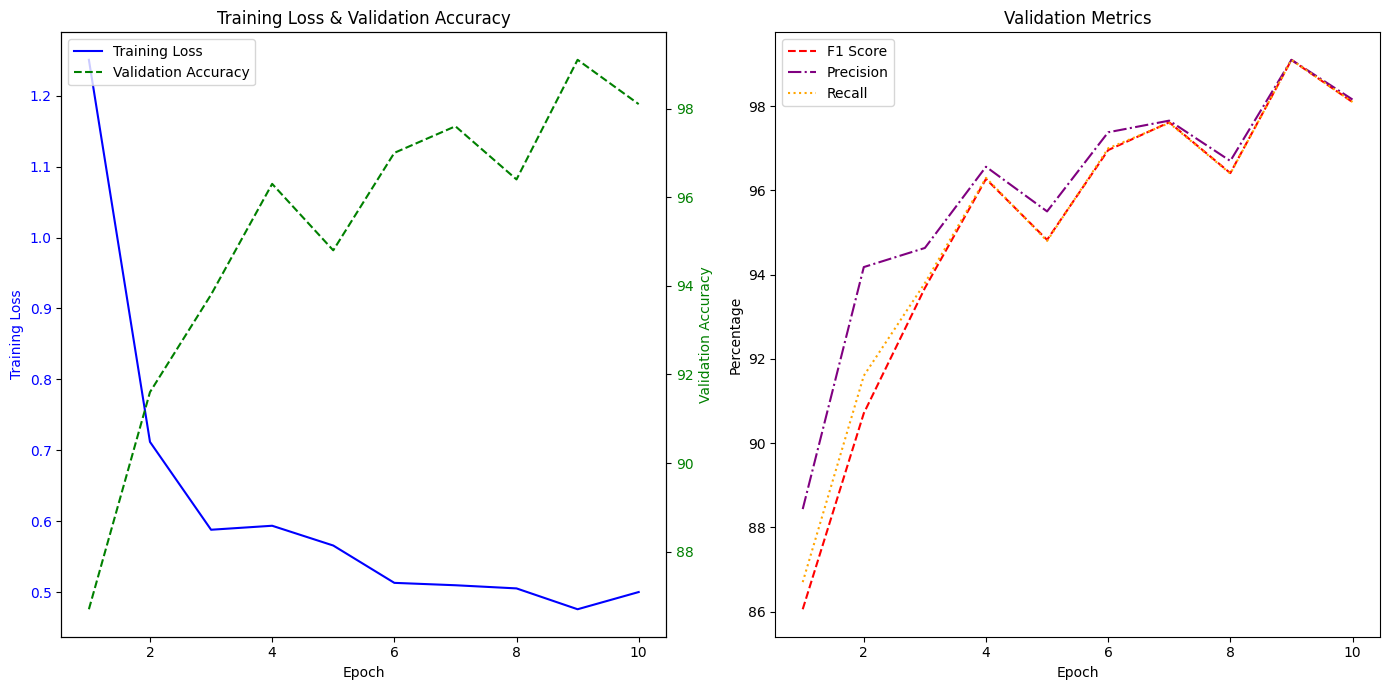

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoFeatureExtractor, CvtForImageClassification
from PIL import Image
import requests
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Dataset and DataLoader setup
# Update paths for Kaggle dataset
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/testset', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model setup using CVT-13
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13', do_rescale=False)
model = CvtForImageClassification.from_pretrained('microsoft/cvt-13', num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and evaluation
num_epochs = 10
train_losses = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        inputs = feature_extractor(images=images, return_tensors="pt").to(device)
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            _, preds = torch.max(outputs.logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * accuracy_score(all_labels, all_preds)
    f1 = 100 * f1_score(all_labels, all_preds, average='macro')
    precision = 100 * precision_score(all_labels, all_preds, average='macro')
    recall = 100 * recall_score(all_labels, all_preds, average='macro')

    val_accuracies.append(val_accuracy)
    val_f1_scores.append(f1)
    val_precisions.append(precision)
    val_recalls.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Accuracy: {val_accuracy:.2f}%, '
          f'F1 Score: {f1:.2f}%, '
          f'Precision: {precision:.2f}%, '
          f'Recall: {recall:.2f}%')

# Save the trained model
torch.save(model.state_dict(), './cvt_13_model.pth')

# Plotting
plt.figure(figsize=(14, 7))

# Plot Training Loss and Validation Accuracy
ax1 = plt.subplot(1, 2, 1)
lns1 = ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', linestyle='-')
ax2 = ax1.twinx()
lns2 = ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green', linestyle='--')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color='blue')
ax2.set_ylabel('Validation Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Training Loss & Validation Accuracy')

# Plot Validation Metrics
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='F1 Score', linestyle='--', color='red')
plt.plot(range(1, num_epochs + 1), val_precisions, label='Precision', linestyle='-.', color='purple')
plt.plot(range(1, num_epochs + 1), val_recalls, label='Recall', linestyle=':', color='orange')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


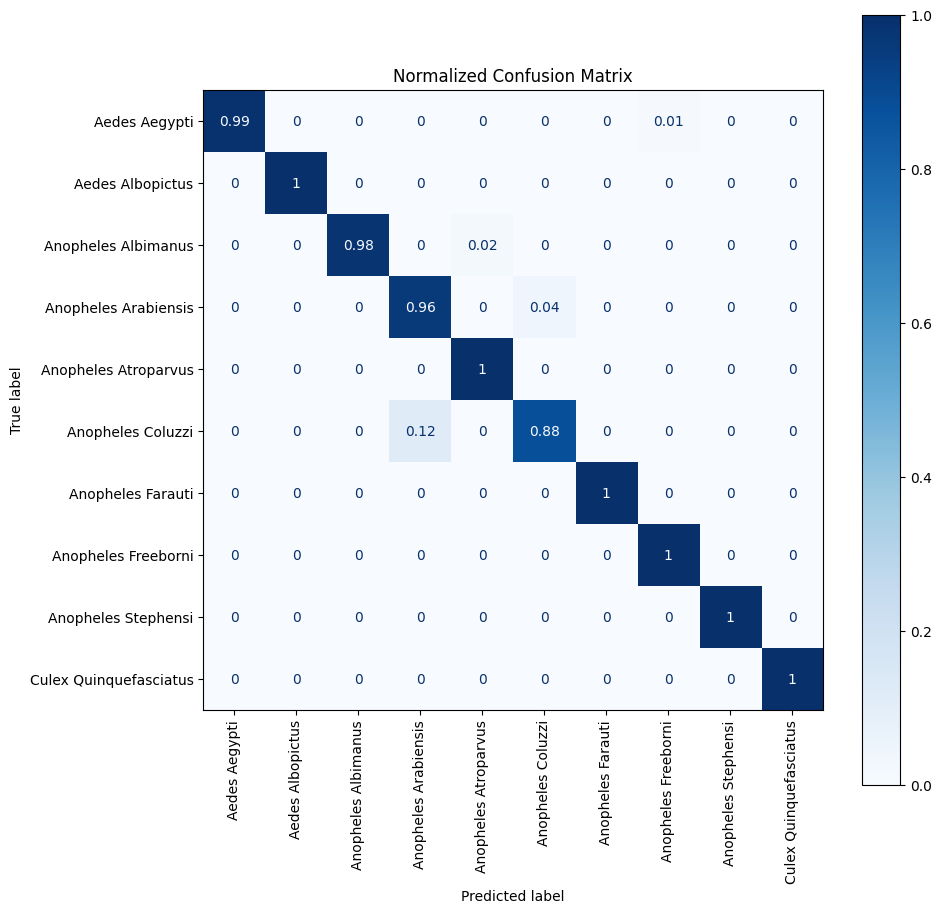

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming the completion of the training and validation phase
# and you have `all_labels` and `all_preds`

# Define class names manually based on your dataset
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Normalized Confusion Matrix')
plt.show()


OPEN MAX IMPLEMENTATION

In [2]:
# Install libmr, which is required for Weibull fitting
!pip install libmr


  Preparing metadata (setup.py) ... done
  Created wheel for libmr: filename=libmr-0.1.9-cp310-cp310-linux_x86_64.whl size=140084 sha256=fc1f49e2e7ee62444bdc1911fa09c2ca28be0d41011bb67aadaf7059efb767d7
  Stored in directory: /root/.cache/pip/wheels/8a/e0/45/ec5f4f802b034150d6f5735922408cc0278bf85582b2a1a954
Successfully built libmr


In [8]:
# Dataset and DataLoader setup
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

openmax_test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/TestSet_Openmax/TestSet_Openmax', transform=test_transform)
openmax_test_dataset.class_to_idx = {
    'Aedes Aegypti': 0,
    'Aedes Albopictus': 1,
    'Anopheles Albimanus': 2,
    'Anopheles Arabiensis': 3,
    'Anopheles Atroparvus': 4,
    'Anopheles Coluzzi': 5,
    'Anopheles Farauti': 6,
    'Anopheles Freeborni': 7,
    'Anopheles Stephensi': 8,
    'Culex Quinquefasciatus': 9,
    'Bee': 10,
    'Butterfly': 11,
    'Fly': 12
}
openmax_test_loader = DataLoader(openmax_test_dataset, batch_size=32, shuffle=False)


In [24]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoFeatureExtractor, CvtForImageClassification
import libmr
from sklearn.metrics import accuracy_score

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

openmax_test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/TestSet_Openmax/TestSet_Openmax', transform=test_transform)
openmax_test_loader = DataLoader(openmax_test_dataset, batch_size=32, shuffle=False)

# Load and configure the model
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13', do_rescale=False)
model = CvtForImageClassification.from_pretrained('microsoft/cvt-13', num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True)
model_path = '/kaggle/input/cvt13/pytorch/cvt13/1/cvt_13_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Function to extract features
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            features.append(outputs.logits.detach().cpu())
            labels.extend(targets)
    features = torch.cat(features).to(device)
    labels = torch.tensor(labels).to(device)
    return features, labels

# Extract features from the training set
train_features, train_labels = extract_features(model, train_loader, device)

# Fit Weibull models and calculate mavs
def fit_weibull_models(features, labels, tail_size=20, device=device):
    mavs = []
    weibull_models = []
    for i in range(len(train_dataset.classes)):
        class_indices = (labels == i).nonzero(as_tuple=True)[0]
        class_features = features[class_indices]
        mav = class_features.mean(0).to(device)
        mavs.append(mav)
        dists = torch.norm(class_features - mav, p=2, dim=1)
        mr = libmr.MR()
        tailtofit = np.sort(dists.cpu().numpy())[-tail_size:]
        mr.fit_high(tailtofit, len(tailtofit))
        weibull_models.append(mr)
    return mavs, weibull_models

mavs, weibull_models = fit_weibull_models(train_features, train_labels, device=device)

# Implement the OpenMax function
def openmax(mavs, weibull_models, logits, alpha=10, device=device):
    logits = logits.to(device)
    scores = torch.nn.functional.softmax(logits, dim=1)
    adjusted_scores = torch.zeros_like(scores).to(device)
    for i in range(logits.shape[0]):
        for j in range(scores.shape[1]):
            mav_dist = torch.norm(logits[i] - mavs[j])
            weibull_score = weibull_models[j].w_score(mav_dist.item())
            adjusted_scores[i, j] = scores[i, j] * (1 - alpha * weibull_score)
    total_weibull_score = torch.sum(adjusted_scores, dim=1, keepdim=True)
    unknown_scores = 1 - total_weibull_score
    final_scores = torch.cat((adjusted_scores, unknown_scores), dim=1)
    return final_scores

# Test the model with OpenMax
def test_openmax(model, data_loader, device, feature_extractor, mavs, weibull_models, alpha=10):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            openmax_scores = openmax(mavs, weibull_models, outputs.logits, alpha, device)
            _, predicted = torch.max(openmax_scores, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Compute OpenMax test accuracy
openmax_accuracy = test_openmax(model, openmax_test_loader, device, feature_extractor, mavs, weibull_models, alpha=10)
print(f"OpenMax Test Accuracy: {openmax_accuracy * 100:.2f}%")


Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OpenMax Test Accuracy: 63.38%


In [29]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoFeatureExtractor, CvtForImageClassification
import libmr
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

openmax_test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/TestSet_Openmax/TestSet_Openmax', transform=test_transform)
openmax_test_dataset.class_to_idx = {
    'Aedes Aegypti': 0,
    'Aedes Albopictus': 1,
    'Anopheles Albimanus': 2,
    'Anopheles Arabiensis': 3,
    'Anopheles Atroparvus': 4,
    'Anopheles Coluzzi': 5,
    'Anopheles Farauti': 6,
    'Anopheles Freeborni': 7,
    'Anopheles Stephensi': 8,
    'Culex Quinquefasciatus': 9,
    'Bee': 10,
    'Butterfly': 11,
    'Fly': 12
}
openmax_test_loader = DataLoader(openmax_test_dataset, batch_size=32, shuffle=False)

# Load and configure the model
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13', do_rescale=False)
model = CvtForImageClassification.from_pretrained('microsoft/cvt-13', num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True)
model_path = '/kaggle/input/cvt13/pytorch/cvt13/1/cvt_13_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Function to extract features
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            features.append(outputs.logits.detach().cpu())
            labels.extend(targets)
    features = torch.cat(features).to(device)
    labels = torch.tensor(labels).to(device)
    return features, labels

# Extract features from the training set
train_features, train_labels = extract_features(model, train_loader, device)

# Fit Weibull models and calculate mavs
def fit_weibull_models(features, labels, tail_size=20, device=device):
    mavs = []
    weibull_models = []
    for i in range(len(train_dataset.classes)):
        class_indices = (labels == i).nonzero(as_tuple=True)[0]
        class_features = features[class_indices]
        mav = class_features.mean(0).to(device)
        mavs.append(mav)
        dists = torch.norm(class_features - mav, p=2, dim=1)
        mr = libmr.MR()
        tailtofit = np.sort(dists.cpu().numpy())[-tail_size:]
        mr.fit_high(tailtofit, len(tailtofit))
        weibull_models.append(mr)
    return mavs, weibull_models

mavs, weibull_models = fit_weibull_models(train_features, train_labels, device=device)

# Implement the OpenMax function
def openmax(mavs, weibull_models, logits, alpha=10, device=device):
    logits = logits.to(device)
    scores = torch.nn.functional.softmax(logits, dim=1)
    adjusted_scores = torch.zeros_like(scores).to(device)
    for i in range(logits.shape[0]):
        for j in range(scores.shape[1]):
            mav_dist = torch.norm(logits[i] - mavs[j])
            weibull_score = weibull_models[j].w_score(mav_dist.item())
            adjusted_scores[i, j] = scores[i, j] * (1 - alpha * weibull_score)
    total_weibull_score = torch.sum(adjusted_scores, dim=1, keepdim=True)
    unknown_scores = 1 - total_weibull_score
    final_scores = torch.cat((adjusted_scores, unknown_scores), dim=1)
    return final_scores

# Test the model with OpenMax and print accuracy and F1 score
def test_openmax(model, data_loader, device, feature_extractor, mavs, weibull_models, alpha=10):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            openmax_scores = openmax(mavs, weibull_models, outputs.logits, alpha, device)
            _, predicted = torch.max(openmax_scores, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("F1 Score: {:.2f}".format(f1))
    return accuracy, f1

# Compute OpenMax test accuracy and F1 score
openmax_accuracy, openmax_f1 = test_openmax(model, openmax_test_loader, device, feature_extractor, mavs, weibull_models, alpha=10)


/opt/conda/lib/python3.10/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 62.77%
F1 Score: 57.69


In [31]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoFeatureExtractor, CvtForImageClassification
import libmr
from sklearn.metrics import accuracy_score, f1_score

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

openmax_test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)
openmax_test_dataset.class_to_idx = {
    'Aedes Aegypti': 0,
    'Aedes Albopictus': 1,
    'Anopheles Albimanus': 2,
    'Anopheles Arabiensis': 3,
    'Anopheles Atroparvus': 4,
    'Anopheles Coluzzi': 5,
    'Anopheles Farauti': 6,
    'Anopheles Freeborni': 7,
    'Anopheles Stephensi': 8,
    'Culex Quinquefasciatus': 9,
    'Bee': 10,
    'Butterfly': 11,
    'Fly': 12
}
openmax_test_loader = DataLoader(openmax_test_dataset, batch_size=32, shuffle=False)

# Load and configure the model
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13', do_rescale=False)
model = CvtForImageClassification.from_pretrained('microsoft/cvt-13', num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True)
model_path = '/kaggle/input/cvt13/pytorch/cvt13/1/cvt_13_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Define class weights for loss function
class_weights = torch.tensor([1.0]*10 + [2.0]*3, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Function to extract features
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            features.append(outputs.logits.detach().cpu())
            labels.extend(targets)
    features = torch.cat(features).to(device)
    labels = torch.tensor(labels).to(device)
    return features, labels

# Extract features from the training set
train_features, train_labels = extract_features(model, train_loader, device)

# Fit Weibull models and calculate mavs
def fit_weibull_models(features, labels, tail_size=20, device=device):
    mavs = []
    weibull_models = []
    for i in range(len(train_dataset.classes)):
        class_indices = (labels == i).nonzero(as_tuple=True)[0]
        class_features = features[class_indices]
        mav = class_features.mean(0).to(device)
        mavs.append(mav)
        dists = torch.norm(class_features - mav, p=2, dim=1)
        mr = libmr.MR()
        tailtofit = np.sort(dists.cpu().numpy())[-tail_size:]
        mr.fit_high(tailtofit, len(tailtofit))
        weibull_models.append(mr)
    return mavs, weibull_models

mavs, weibull_models = fit_weibull_models(train_features, train_labels, device=device)

# Implement the OpenMax function
def openmax(mavs, weibull_models, logits, alpha=10, device=device):
    logits = logits.to(device)
    scores = torch.nn.functional.softmax(logits, dim=1)
    adjusted_scores = torch.zeros_like(scores).to(device)
    for i in range(logits.shape[0]):
        for j in range(scores.shape[1]):
            mav_dist = torch.norm(logits[i] - mavs[j])
            weibull_score = weibull_models[j].w_score(mav_dist.item())
            adjusted_scores[i, j] = scores[i, j] * (1 - alpha * weibull_score)
    total_weibull_score = torch.sum(adjusted_scores, dim=1, keepdim=True)
    unknown_scores = 1 - total_weibull_score
    final_scores = torch.cat((adjusted_scores, unknown_scores), dim=1)
    return final_scores

# Test the model with OpenMax and print accuracy and F1 score
def test_openmax(model, data_loader, device, feature_extractor, mavs, weibull_models, alpha=10):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            openmax_scores = openmax(mavs, weibull_models, outputs.logits, alpha, device)
            _, predicted = torch.max(openmax_scores, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("F1 Score: {:.2f}".format(f1))
    return accuracy, f1

# Compute OpenMax test accuracy and F1 score
openmax_accuracy, openmax_f1 = test_openmax(model, openmax_test_loader, device, feature_extractor, mavs, weibull_models, alpha=10)


/opt/conda/lib/python3.10/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 87.80%
F1 Score: 0.89


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoFeatureExtractor, CvtForImageClassification
import libmr
from sklearn.metrics import accuracy_score, f1_score

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

openmax_test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/TestSet_Openmax/TestSet_Openmax', transform=test_transform)
openmax_test_dataset.class_to_idx = {
    'Aedes Aegypti': 0,
    'Aedes Albopictus': 1,
    'Anopheles Albimanus': 2,
    'Anopheles Arabiensis': 3,
    'Anopheles Atroparvus': 4,
    'Anopheles Coluzzi': 5,
    'Anopheles Farauti': 6,
    'Anopheles Freeborni': 7,
    'Anopheles Stephensi': 8,
    'Culex Quinquefasciatus': 9,
    'Bee': 10,
    'Butterfly': 11,
    'Fly': 12
}
openmax_test_loader = DataLoader(openmax_test_dataset, batch_size=32, shuffle=False)

# Load and configure the model
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13', do_rescale=False)
model = CvtForImageClassification.from_pretrained('microsoft/cvt-13', num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True)
model_path = '/kaggle/input/cvt13/pytorch/cvt13/1/cvt_13_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Define class weights for loss function
class_weights = torch.tensor([1.0]*10 + [2.0]*3, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Function to extract features
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            features.append(outputs.logits.detach().cpu())
            labels.extend(targets)
    features = torch.cat(features).to(device)
    labels = torch.tensor(labels).to(device)
    return features, labels

# Extract features from the training set
train_features, train_labels = extract_features(model, train_loader, device)

# Fit Weibull models and calculate mavs
def fit_weibull_models(features, labels, tail_size=20, device=device):
    mavs = []
    weibull_models = []
    for i in range(len(train_dataset.classes)):
        class_indices = (labels == i).nonzero(as_tuple=True)[0]
        class_features = features[class_indices]
        mav = class_features.mean(0).to(device)
        mavs.append(mav)
        dists = torch.norm(class_features - mav, p=2, dim=1)
        mr = libmr.MR()
        tailtofit = np.sort(dists.cpu().numpy())[-tail_size:]
        mr.fit_high(tailtofit, len(tailtofit))
        weibull_models.append(mr)
    return mavs, weibull_models

mavs, weibull_models = fit_weibull_models(train_features, train_labels, device=device)

# Implement the OpenMax function
def openmax(mavs, weibull_models, logits, alpha=10, device=device):
    logits = logits.to(device)
    scores = torch.nn.functional.softmax(logits, dim=1)
    adjusted_scores = torch.zeros_like(scores).to(device)
    for i in range(logits.shape[0]):
        for j in range(scores.shape[1]):
            mav_dist = torch.norm(logits[i] - mavs[j])
            weibull_score = weibull_models[j].w_score(mav_dist.item())
            adjusted_scores[i, j] = scores[i, j] * (1 - alpha * weibull_score)
    total_weibull_score = torch.sum(adjusted_scores, dim=1, keepdim=True)
    unknown_scores = 1 - total_weibull_score
    final_scores = torch.cat((adjusted_scores, unknown_scores), dim=1)
    return final_scores

# Test the model with OpenMax and print accuracy and F1 score
def test_openmax(model, data_loader, device, feature_extractor, mavs, weibull_models, alpha=10):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            openmax_scores = openmax(mavs, weibull_models, outputs.logits, alpha, device)
            _, predicted = torch.max(openmax_scores, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("F1 Score: {:.2f}".format(f1))
    return accuracy, f1

# Compute OpenMax test accuracy and F1 score
openmax_accuracy, openmax_f1 = test_openmax(model, openmax_test_loader, device, feature_extractor, mavs, weibull_models, alpha=10)
